In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import cartopy.io.img_tiles as cimgt
import pandas as pd
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from scipy import ndimage, interpolate

import metpy.calc as mpcalc
from metpy.plots import simple_layout, StationPlot, StationPlotLayout
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units

from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

from boto.s3.connection import S3Connection
import tempfile

import datetime
from copy import deepcopy

import pyart
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [12]:
#Now our nifty fetch script
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    # First create the query string for the bucket knowing
    # how NOAA and AWS store the data
    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    # Connect to the bucket
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    # Get a list of files
    bucket_list = list(bucket.list(prefix = my_pref))

    # we are going to create a list of keys and datetimes to allow easy searching
    keys = []
    datetimes = []

    # populate the list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    # find the closest available radar to your datetime
    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar
# plot a scale bar with 4 subdivisions on the left side of the map
def scale_bar_left(ax, bars=4, length=None, location=(0.1, 0.05), linewidth=3, col='black',
                  fs=None, oset=2000):
    """
    ax is the axes to draw the scalebar on.
    bars is the number of subdivisions of the bar (black and white chunks)
    length is the length of the scalebar in km.
    location is left side of the scalebar in axis coordinates.
    (ie. 0 is the left side of the plot)
    linewidth is the thickness of the scalebar.
    color is the color of the scale bar
    """
    # Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    # Make tmc aligned to the left of the map,
    # vertically at scale bar location
    sbllx = llx0 + (llx1 - llx0) * location[0]
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    # Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    # Calculate a scale bar length if none has been given
    # (Theres probably a more pythonic way of rounding the number but this works)
    if not length:
        length = (x1 - x0) / 5000  # in km
        ndim = int(np.floor(np.log10(length)))  # number of digits in number
        length = round(length, -ndim)  # round to 1sf

        # Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']:
                return int(x)
            else:
                return scale_number(x - 10 ** ndim)

        length = scale_number(length)

    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx, sbx + length * 1000 / bars]
    # Plot the scalebar chunks
    barcol = 'yellow'
    for i in range(0, bars):
        # plot the chunk
        ax.plot(bar_xs, [sby, sby], transform=tmc, color=barcol, linewidth=linewidth)
        # alternate the colour
        if barcol == 'yellow':
            barcol = 'blue'
        else:
            barcol = 'yellow'
        # Generate the x coordinate for the number
        bar_xt = sbx + i * length * 1000 / bars
        # Plot the scalebar label for that chunk
        ax.text(bar_xt, sby + oset, str(round(i * length / bars)), transform=tmc,
                horizontalalignment='center', verticalalignment='bottom',
                color=col, fontsize=fs)
        # work out the position of the next chunk of the bar
        bar_xs[0] = bar_xs[1]
        bar_xs[1] = bar_xs[1] + length * 1000 / bars
    # Generate the x coordinate for the last number
    bar_xt = sbx + length * 1000
    # Plot the last scalebar label
    ax.text(bar_xt, sby + oset , str(round(length)), transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color=col, fontsize=fs)
    # Plot the unit label below the bar
    bar_xt = sbx + length * 1000 / 2
    bar_yt = y0 + (y1 - y0) * (location[1] / 4)
    ax.text(bar_xt, bar_yt, 'km', transform=tmc, horizontalalignment='center',
            verticalalignment='bottom', color=col, fontsize=fs)

def get_texture(radar, nyq=None):
    """ Calculates velocity texture field. """
    if nyq is None:
        nyq = radar.instrument_parameters['nyquist_velocity']['data'][0]
    else:
        nyq = nyq
    std_dev = pyart.util.angular_texture_2d(radar.fields['velocity']['data'],
                                            4, nyq)
    filtered_data = ndimage.filters.median_filter(std_dev, size=(4, 4))
    texture_field = pyart.config.get_metadata('velocity')
    texture_field['data'] = filtered_data
    return texture_field

def namefilter(dframe, radius):
    proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])
    point_locs = proj.transform_points(ccrs.PlateCarree(), dframe['Longitude'].values, dframe['Latitude'].values)
    indexes_dc = reduce_point_density(point_locs, radius)
    ndframe = dframe[indexes_dc]
    return ndframe

def plot_points_from_df(dframe, sym='r*', ssize=12, label=None):
    iamfirst = True
    for index, row in dframe.iterrows():
        if iamfirst:
            plt.plot(row['Longitude'], row['Latitude'], sym,
                     transform=ccrs.PlateCarree(), markersize=ssize, label=label)
            iamfirst = False
        else:
            plt.plot(row['Longitude'], row['Latitude'], sym,
                     transform=ccrs.PlateCarree(), markersize=ssize)


def plot_text(dframe, dx=0.01, dy=0.01, tcol='c', fontsize=20):
    for index, row in dframe.iterrows():
        plt.text(row['Longitude']+dx, row['Latitude']+dy, row['SiteName'],transform=ccrs.PlateCarree(),
                fontsize=fontsize, color=tcol, alpha=1, weight='bold')
    
wx_code_map = {'': 0, 'DU':7, 'BLDU':7, 'HZ': 5, 'BR': 10, '-UP':16, 'UP': 16, 'SQ': 18, 'FC': 19,
               'DRSN': 36, 'FG': 45, 'FZFG': 49, '-DZ': 51, 'DZ': 53, '+DZ': 55,
               '-RA': 61, 'RA': 63, '+RA': 65, '-FZRA': 66,
               '-SN': 71, 'SN': 73, '+SN': 75, '-SHRA': 80, 'SHRA': 81, '-SHSN': 85, '+TSRA' : 97,
              'TSRA' : 95}
def to_code(text):
    for s in text:
        if ' ' in s:
            yield max(to_code(s.split()))
        else:
            yield wx_code_map[s]

In [108]:
radar_targ = 'NEXRAD'

In [109]:
if radar_targ == 'ARM':
    radar_file = '/data/xstage/scanning_exp/XNW180525125005.RAW077J'
    radar = pyart.io.read(radar_file)

    dateobj = np.datetime64(radar.time['units'][14:])
    ts = pd.to_datetime(str(dateobj)) 
    d = ts.strftime('%Y%m%d_%H%M')
    rname = radar_file.split('/')[-1][0:3]
elif radar_targ == 'NEXRAD':
    station = 'KVNX'
    my_datetime = datetime.datetime.utcnow()
    radar = get_radar_from_aws(station, my_datetime)
    dateobj = np.datetime64(radar.time['units'][14:])
    ts = pd.to_datetime(str(dateobj)) 
    d = ts.strftime('%Y%m%d_%H%M')
    rname = 'KVNX'


ERROR:boto:Caught exception reading instance data
Traceback (most recent call last):
  File "/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/http/client.py", line 964, in send
    se

In [110]:
sgp_df = pd.read_excel('../data/All Sites Lats Longs, and distance from CF. More Accurate[1].xlsx')
sgp_ef_unformatted = sgp_df[1:18]
sgp_if_unformatted = sgp_df[22:32]

select_idx = ['IF4-Billings, OK', 'IF5-Garber, OK',
             'IF6-Deer Creek, OK', 'E13 - Central Facility']

sgp_select_unformatted = sgp_df[sgp_df['EF LOCATION INFORMATION-More Accurate'].isin(select_idx)]

sgp_select = pd.DataFrame({'SiteName' : sgp_select_unformatted['EF LOCATION INFORMATION-More Accurate'],
                      'Latitude' : sgp_select_unformatted['Unnamed: 2'],
                      'Longitude' : sgp_select_unformatted['Unnamed: 3']})

sgp_ef = pd.DataFrame({'SiteName' : sgp_ef_unformatted['EF LOCATION INFORMATION-More Accurate'],
                      'Latitude' : sgp_ef_unformatted['Unnamed: 2'],
                      'Longitude' : sgp_ef_unformatted['Unnamed: 3']})

sgp_if = pd.DataFrame({'SiteName' : sgp_if_unformatted['EF LOCATION INFORMATION-More Accurate'],
                      'Latitude' : sgp_if_unformatted['Unnamed: 2'],
                      'Longitude' : sgp_if_unformatted['Unnamed: 3']})



In [111]:
tex = get_texture(radar)
radar.add_field('texture', tex)

/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/site-packages/pyart/util/sigmath.py:62: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(-2 * np.log(norm)) * (half_width) / np.pi


In [112]:
sig_fet = pyart.filters.GateFilter(radar)
sig_fet.exclude_above('texture', 5.0)
sig_fet.exclude_below('cross_correlation_ratio', 0.93)
#sig_fet.exclude_below('normalized_coherent_power', 0.4)


/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/site-packages/pyart/filters/gatefilter.py:448: RuntimeWarning: invalid value encountered in greater
  marked = self._get_fdata(field) > value


In [113]:
ex = [-98.2, -96.9, 36.1, 37.1]#[-98.7, -96.5, 35.6, 37.4]
mybb = {'north' : ex[3], 'south': ex[2], 'east' : ex[0], 'west' : ex[1]}

In [114]:
# copied from the browser url box
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
# parse the xml
metar_cat = TDSCatalog(metar_cat_url)
# what datasets are here? only one "dataset" in this catalog
dataset = list(metar_cat.datasets.values())[0]
ncss_url = dataset.access_urls["NetcdfSubset"]
ncss = NCSS(ncss_url)

query = ncss.query().accept('csv').time(ts)
query.lonlat_box(**mybb)
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction', 'weather')
data = ncss.get_data(query)

try:
    lats = data['latitude'][:]
    lons = data['longitude'][:]
    tair = data['air_temperature'][:]
    dewp = data['dew_point_temperature'][:]
    slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

    # Convert wind to components
    u, v = mpcalc.get_wind_components(data['wind_speed'] * units.knot,
                                      data['wind_from_direction'] * units.deg)

    # Need to handle missing (NaN) and convert to proper code
    cloud_cover = 8 * data['cloud_area_fraction']
    cloud_cover[np.isnan(cloud_cover)] = 9
    cloud_cover = cloud_cover.astype(np.int)

    # For some reason these come back as bytes instead of strings
    stid = [s.decode() for s in data['station']]



    # Convert the text weather observations to WMO codes we can map to symbols
    if data['weather'].dtype != bool:
        wx_text = [s.decode('ascii') for s in data['weather']]
        wx_codes = np.array(list(to_code(wx_text)))
    else:
        wx_codes = np.array([0]*len(data['weather']))

    sfc_data = {'latitude': lats, 'longitude': lons,
                'air_temperature': tair, 'dew_point_temperature': dewp, 'eastward_wind': u,
                'northward_wind': v, 'cloud_coverage': cloud_cover,
                'air_pressure_at_sea_level': slp, 'present_weather': wx_codes}

    have_obs = True
except IndexError:
    have_obs = False


/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/site-packages/siphon/ncss.py:433: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  converters={'date': lambda s: parse_iso_date(s.decode('utf-8'))})


/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/site-packages/cartopy/img_transform.py:76: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


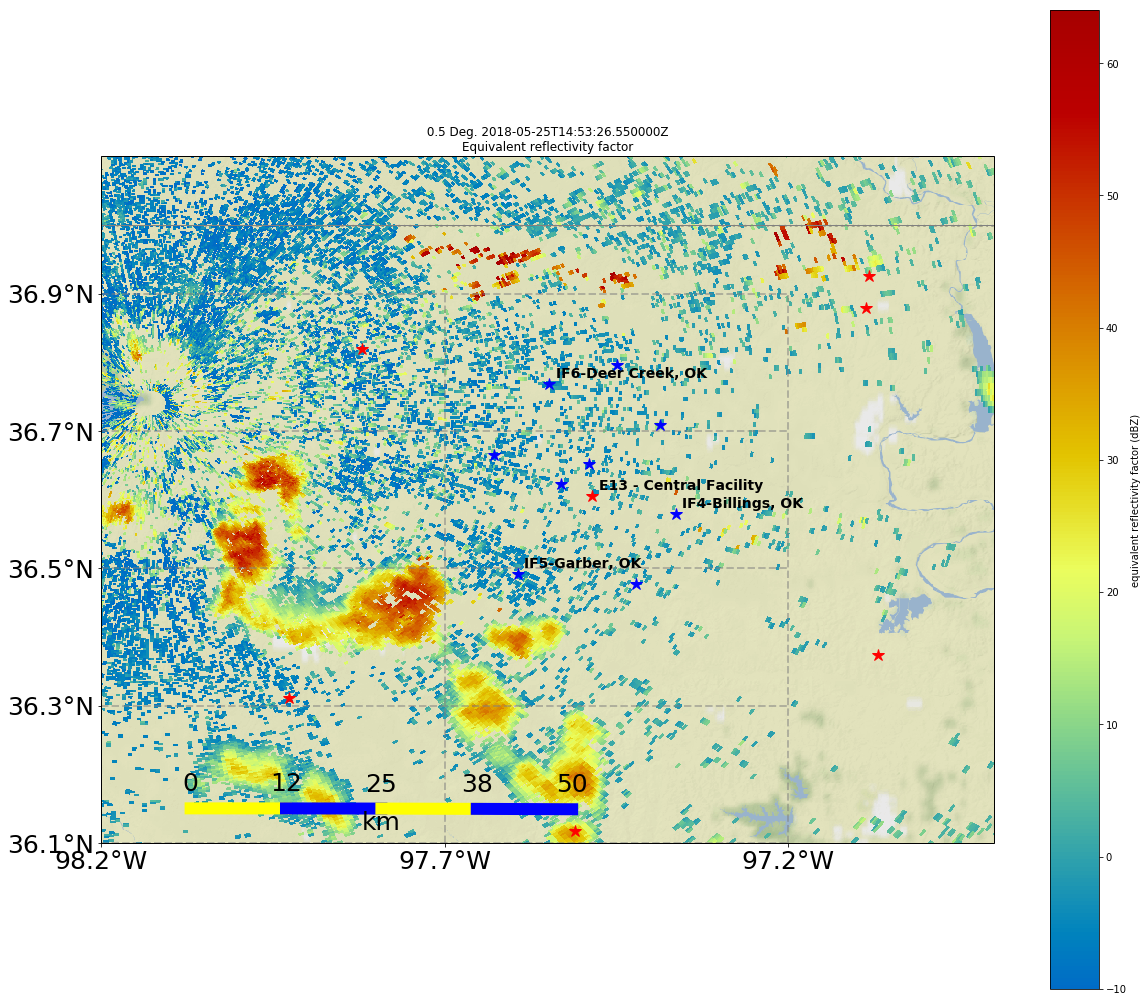

In [105]:
myf = plt.figure(figsize=[20,18])
proj = ccrs.PlateCarree()
mydisplay = pyart.graph.RadarMapDisplayCartopy(radar)
mydisplay.plot_ppi_map('reflectivity', sweep=0, 
                       cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                      embelish=False, vmin=-10, vmax=64,
                      min_lat=mybb['south'], max_lat=mybb['north'],
                      min_lon=mybb['west'], max_lon=mybb['east'],
                      projection = proj,
                      gatefilter=sig_fet)


ax = plt.gca()


ax.set_extent(ex)


lat_lines = np.arange(np.around(ex[2], decimals=1), 
                      ex[3], .2)
lon_lines = np.arange(np.around(ex[0],decimals=1),
                      ex[1], .5)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')




request = cimgt.StamenTerrain()
if True:#len(request.imgs) > 0:
    ax.add_image(request, 10, zorder=0)



plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',
                 xlocs=lon_lines, ylocs=lat_lines)

scale_bar_left(plt.gca(), linewidth=12, fs=25, col='Black', length=50)

plot_points_from_df(sgp_ef, sym='r*', ssize=12, label='Extended Facilities')
plot_points_from_df(sgp_if, sym='b*', ssize=12, label='Intermediate Facilities')
plot_text(sgp_select, dx=0.01, dy=0.01, tcol='k', fontsize=14)

if have_obs:
    stationplot = StationPlot(ax, sfc_data['longitude'], sfc_data['latitude'],
                              transform=ccrs.PlateCarree(),
                              fontsize=12)
    simple_layout.plot(stationplot, sfc_data)


ax.set_aspect(1.1)
plt.savefig('../images/'+rname+'_'+d+'_refl_filtered.png')

/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/site-packages/cartopy/img_transform.py:76: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


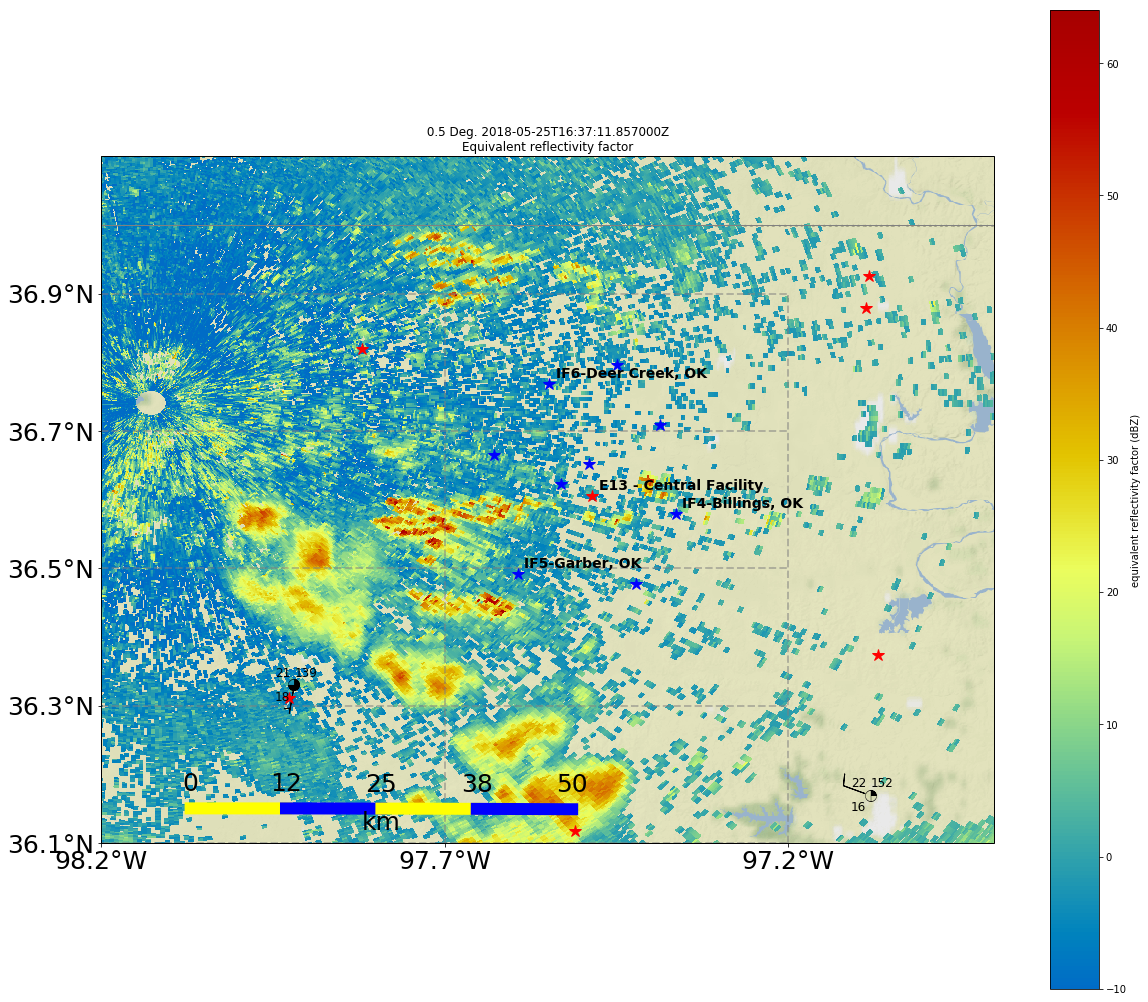

In [115]:
myf = plt.figure(figsize=[20,18])
proj = ccrs.PlateCarree()
mydisplay = pyart.graph.RadarMapDisplayCartopy(radar)
mydisplay.plot_ppi_map('reflectivity', sweep=0, 
                       cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                      embelish=False, vmin=-10, vmax=64,
                      min_lat=mybb['south'], max_lat=mybb['north'],
                      min_lon=mybb['west'], max_lon=mybb['east'],
                      projection = proj)


ax = plt.gca()


ax.set_extent(ex)


lat_lines = np.arange(np.around(ex[2], decimals=1), 
                      ex[3], .2)
lon_lines = np.arange(np.around(ex[0],decimals=1),
                      ex[1], .5)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')




request = cimgt.StamenTerrain()
if True:#len(request.imgs) > 0:
    ax.add_image(request, 10, zorder=0)



plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',
                 xlocs=lon_lines, ylocs=lat_lines)

scale_bar_left(plt.gca(), linewidth=12, fs=25, col='Black', length=50)

plot_points_from_df(sgp_ef, sym='r*', ssize=12, label='Extended Facilities')
plot_points_from_df(sgp_if, sym='b*', ssize=12, label='Intermediate Facilities')
plot_text(sgp_select, dx=0.01, dy=0.01, tcol='k', fontsize=14)

if have_obs:
    stationplot = StationPlot(ax, sfc_data['longitude'], sfc_data['latitude'],
                              transform=ccrs.PlateCarree(),
                              fontsize=12)
    simple_layout.plot(stationplot, sfc_data)


ax.set_aspect(1.1)
plt.savefig('../images/'+rname+'_'+d+'_refl.png')

/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/site-packages/cartopy/img_transform.py:76: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


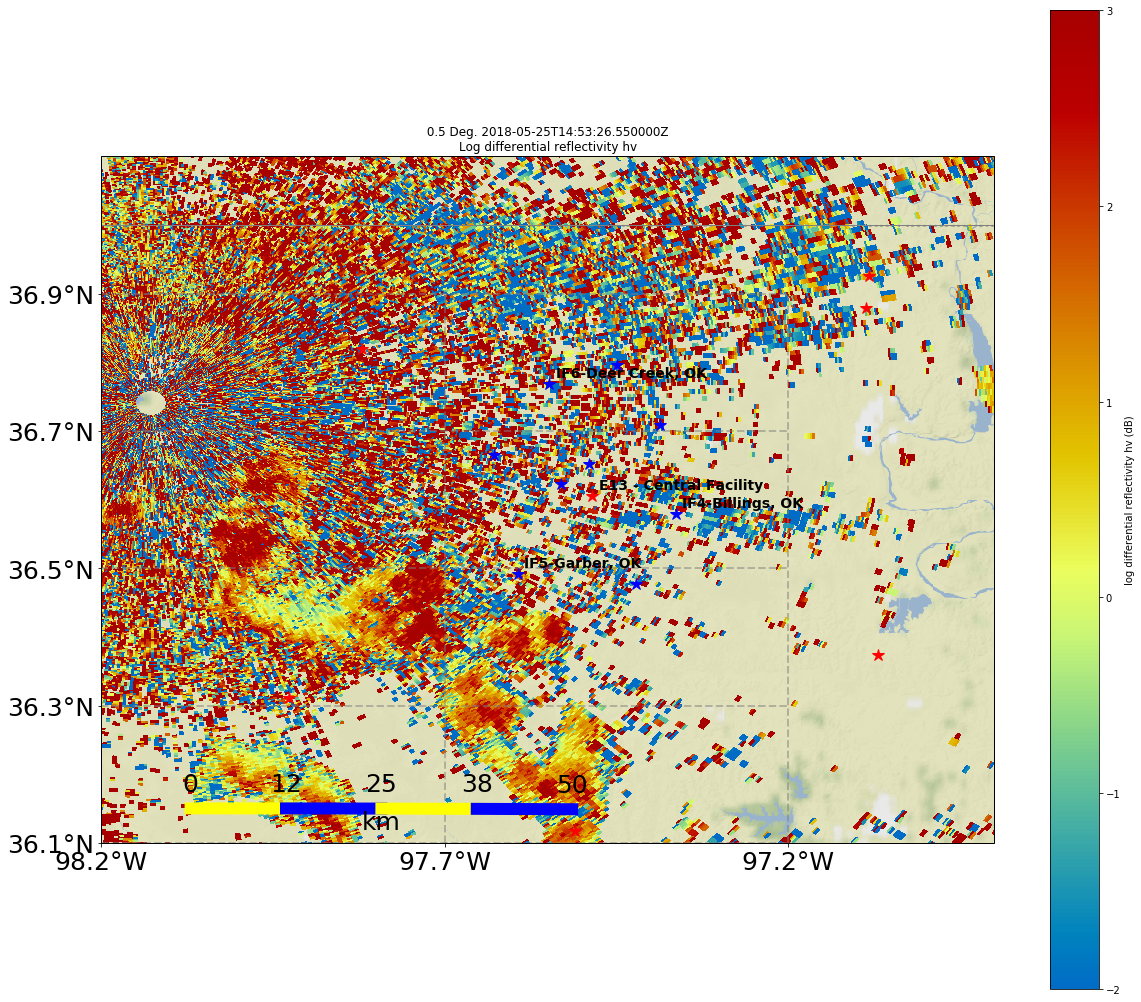

In [107]:
myf = plt.figure(figsize=[20,18])
proj = ccrs.PlateCarree()
mydisplay = pyart.graph.RadarMapDisplayCartopy(radar)
mydisplay.plot_ppi_map('differential_reflectivity', sweep=0, 
                       cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                      embelish=False, vmin=-2, vmax=3,
                      min_lat=mybb['south'], max_lat=mybb['north'],
                      min_lon=mybb['west'], max_lon=mybb['east'],
                      projection = proj)


ax = plt.gca()


ax.set_extent(ex)


lat_lines = np.arange(np.around(ex[2], decimals=1), 
                      ex[3], .2)
lon_lines = np.arange(np.around(ex[0],decimals=1),
                      ex[1], .5)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')




request = cimgt.StamenTerrain()
if True:#len(request.imgs) > 0:
    ax.add_image(request, 10, zorder=0)



plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',
                 xlocs=lon_lines, ylocs=lat_lines)

scale_bar_left(plt.gca(), linewidth=12, fs=25, col='Black', length=50)

plot_points_from_df(sgp_ef, sym='r*', ssize=12, label='Extended Facilities')
plot_points_from_df(sgp_if, sym='b*', ssize=12, label='Intermediate Facilities')
plot_text(sgp_select, dx=0.01, dy=0.01, tcol='k', fontsize=14)

if have_obs:
    stationplot = StationPlot(ax, sfc_data['longitude'], sfc_data['latitude'],
                              transform=ccrs.PlateCarree(),
                              fontsize=12)
    simple_layout.plot(stationplot, sfc_data)


ax.set_aspect(1.1)
plt.savefig('../images/'+rname+'_'+d+'_raw_zdr.png')

/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/site-packages/cartopy/img_transform.py:76: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


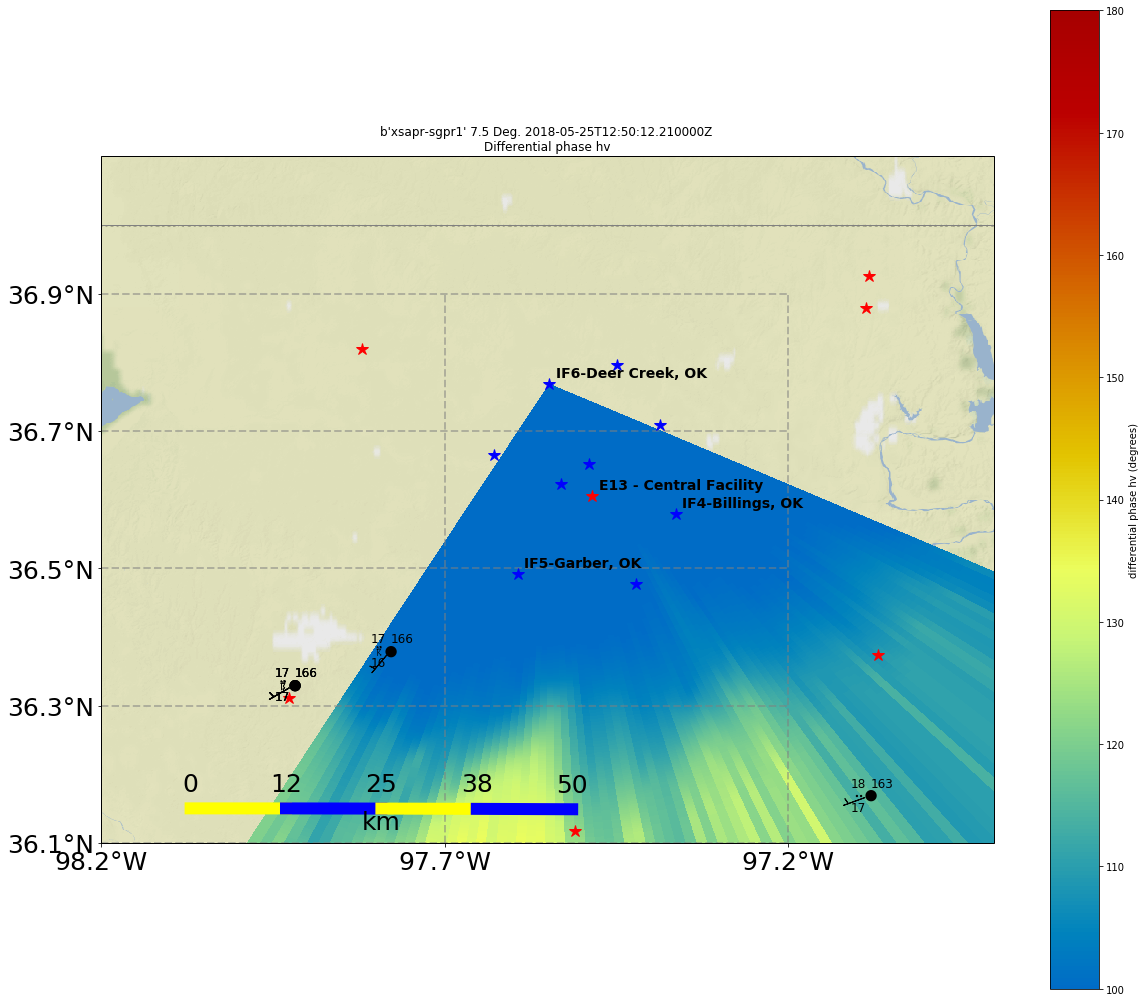

In [88]:
myf = plt.figure(figsize=[20,18])
proj = ccrs.PlateCarree()
mydisplay = pyart.graph.RadarMapDisplayCartopy(radar)
mydisplay.plot_ppi_map('differential_phase', sweep=0, 
                       cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                      embelish=False, vmin=100, vmax=180,
                      min_lat=mybb['south'], max_lat=mybb['north'],
                      min_lon=mybb['west'], max_lon=mybb['east'],
                      projection = proj)


ax = plt.gca()


ax.set_extent(ex)


lat_lines = np.arange(np.around(ex[2], decimals=1), 
                      ex[3], .2)
lon_lines = np.arange(np.around(ex[0],decimals=1),
                      ex[1], .5)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')




request = cimgt.StamenTerrain()
if True:#len(request.imgs) > 0:
    ax.add_image(request, 10, zorder=0)



plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',
                 xlocs=lon_lines, ylocs=lat_lines)

scale_bar_left(plt.gca(), linewidth=12, fs=25, col='Black', length=50)

plot_points_from_df(sgp_ef, sym='r*', ssize=12, label='Extended Facilities')
plot_points_from_df(sgp_if, sym='b*', ssize=12, label='Intermediate Facilities')
plot_text(sgp_select, dx=0.01, dy=0.01, tcol='k', fontsize=14)

if have_obs:
    stationplot = StationPlot(ax, sfc_data['longitude'], sfc_data['latitude'],
                              transform=ccrs.PlateCarree(),
                              fontsize=12)
    simple_layout.plot(stationplot, sfc_data)


ax.set_aspect(1.1)
plt.savefig('../images/'+rname+'_'+d+'_raw_phidp.png')

KeyError: 'specific_differential_phase'

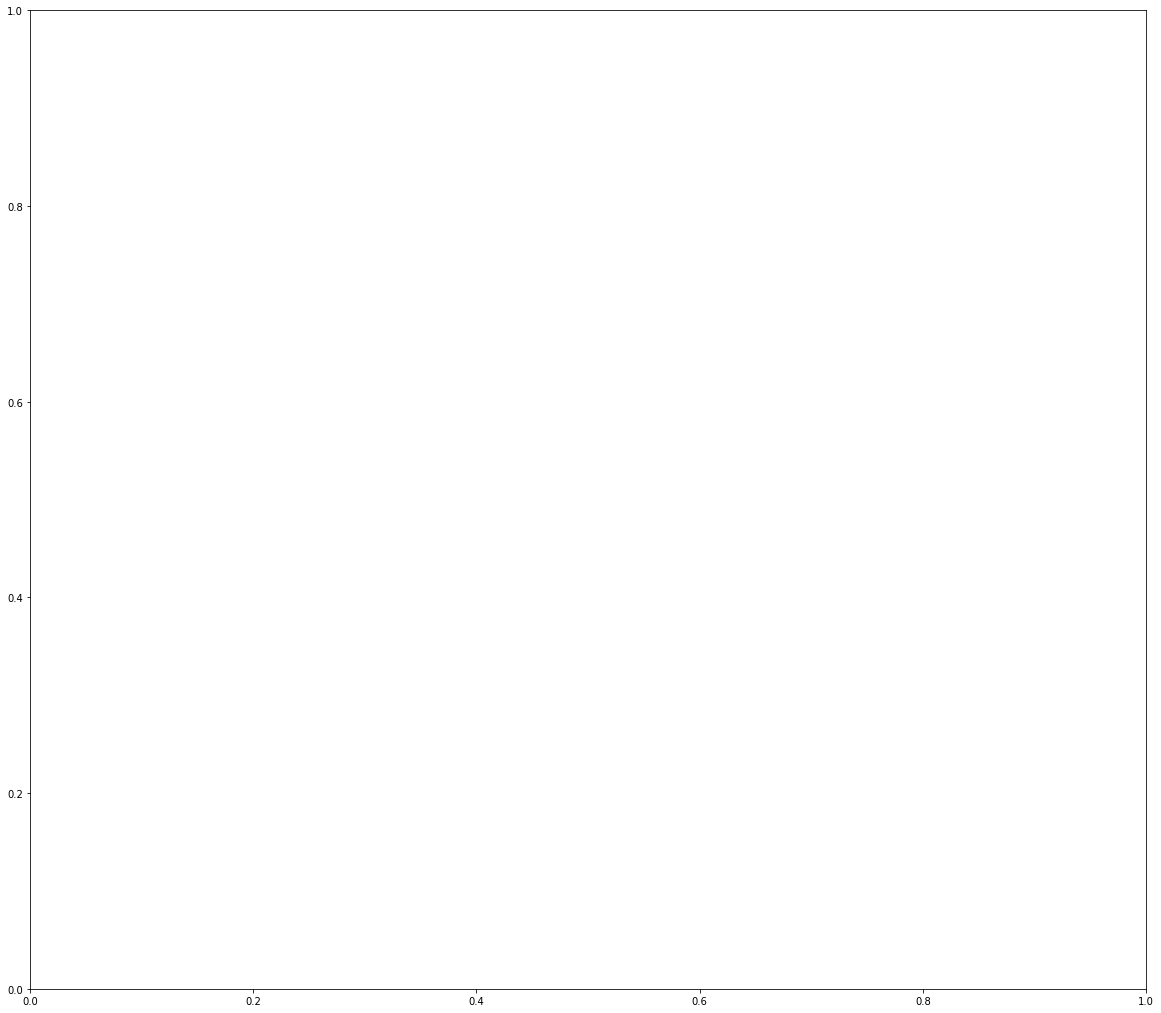

In [104]:
myf = plt.figure(figsize=[20,18])
proj = ccrs.PlateCarree()
mydisplay = pyart.graph.RadarMapDisplayCartopy(radar)
mydisplay.plot_ppi_map('specific_differential_phase', sweep=0, 
                       cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                      embelish=False, vmin=-0.5, vmax=3,
                      min_lat=mybb['south'], max_lat=mybb['north'],
                      min_lon=mybb['west'], max_lon=mybb['east'],
                      projection = proj)


ax = plt.gca()


ax.set_extent(ex)


lat_lines = np.arange(np.around(ex[2], decimals=1), 
                      ex[3], .2)
lon_lines = np.arange(np.around(ex[0],decimals=1),
                      ex[1], .5)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')




request = cimgt.StamenTerrain()
if True:#len(request.imgs) > 0:
    ax.add_image(request, 10, zorder=0)



plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',
                 xlocs=lon_lines, ylocs=lat_lines)

scale_bar_left(plt.gca(), linewidth=12, fs=25, col='Black', length=50)

plot_points_from_df(sgp_ef, sym='r*', ssize=12, label='Extended Facilities')
plot_points_from_df(sgp_if, sym='b*', ssize=12, label='Intermediate Facilities')
plot_text(sgp_select, dx=0.01, dy=0.01, tcol='k', fontsize=14)

if have_obs:
    stationplot = StationPlot(ax, sfc_data['longitude'], sfc_data['latitude'],
                              transform=ccrs.PlateCarree(),
                              fontsize=12)
    simple_layout.plot(stationplot, sfc_data)


ax.set_aspect(1.1)
plt.savefig('../images/'+rname+'_'+d+'_raw_kdp.png')

In [ ]:
radar.fields.keys()

In [ ]:
mydisplay.plot_ppi_map?

In [ ]:
rhi_radar = pyart.util.cross_section_ppi(radar, [50])

In [ ]:
rhi_radar = pyart.util.cross_section_ppi(radar, [120])
myf = plt.figure(figsize=[20,16])
rhi_displ = pyart.graph.RadarDisplay(rhi_radar)
rhi_displ.plot_rhi('differential_reflectivity', cmap = pyart.graph.cm_colorblind.HomeyerRainbow,
                  vmin = -15, vmax=-5)
plt.ylim([0,15])
plt.savefig('../images/'+rname+'_'+d+'_zdr_raw_synrhi.png')

In [ ]:
rhi_radar = pyart.util.cross_section_ppi(radar, [160])
myf = plt.figure(figsize=[20,8])
rhi_displ = pyart.graph.RadarDisplay(rhi_radar)
rhi_displ.plot_rhi('reflectivity', cmap = pyart.graph.cm_colorblind.HomeyerRainbow)
plt.ylim([0,15])
plt.savefig('../images/'+rname+'_'+d+'_refl_raw_synrhi.png')

In [ ]:
rhi_radar = pyart.util.cross_section_ppi(radar, [165])
myf = plt.figure(figsize=[20,8])
rhi_displ = pyart.graph.RadarDisplay(rhi_radar)
rhi_displ.plot_rhi('reflectivity', cmap = pyart.graph.cm_colorblind.HomeyerRainbow)
plt.ylim([0,15])
plt.savefig('../images/'+rname+'_'+d+'_refl_raw_synrhi.png')

In [ ]:
d

In [ ]:
rname = radar_file.split('/')[-1][0:3]

In [ ]:
rname

In [ ]:
sgp_df = pd.read_excel('../data/All Sites Lats Longs, and distance from CF. More Accurate[1].xlsx')

In [59]:
radar.fields.keys()

dict_keys(['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'cross_correlation_ratio', 'normalized_coherent_power', 'differential_phase', 'texture'])

In [ ]:
sgp_df

In [16]:
cimgt.MapQuestOSM?
